# Differentiable Gauss-Newton in PyTorch

Efficiently and accurately computing the Jacobian and Hessian of a function can be a little tricky.

PyTorch now has higher-order function transforms which make it very easy to compute the Jacobian of a function. We can use these to build efficient optimization routines, such as Gauss-Newton and Levenberg-Marquadt, which compute approximations of the Hessian for better informed optimization.

In this notebook, I adapt an example from a biology experiment referenced on Wikipedia and test to see if we can achieve the same result. We then go a step further and add a stochastic outer-optimization loop to try to find the optimal step size / damping parameter for the problem of direct image registration.

https://en.wikipedia.org/wiki/Gauss–Newton_algorithm#Example

In [1]:
import torch
import numpy as np

First, create our data.

In [2]:
concentration = torch.tensor([0.038, 0.194, 0.425, 0.626, 1.253, 2.5, 3.74])
rate = torch.tensor([0.05, 0.127, 0.094, 0.2122, 0.2729, 0.2665, 0.3317])

Define a residual function to evaluate the fitness of our model parameters, $\beta$

In [3]:
def residuals(betas):
    b1, b2 = betas
    return rate - (b1 * concentration) / (b2 + concentration)

Our optimizer requires that we are able to compute the Jacobian with respect to the model parameters.

We can compute these automatically using `torch.autograd.functional.jacobian`.

In [4]:
jac_residuals = torch.autograd.functional.jacobian(residuals, torch.tensor([1.0, 1.0]))

print(jac_residuals)

tensor([[-0.0366,  0.0353],
        [-0.1625,  0.1361],
        [-0.2982,  0.2093],
        [-0.3850,  0.2368],
        [-0.5561,  0.2468],
        [-0.7143,  0.2041],
        [-0.7890,  0.1665]])


Below is an extremely simple gauss newton optimization routine, which just runs for a fixed number of iterations.

Because the number of iterations is always fixed, we can avoid writing any code that deals with numerical stopping criteria.

In [5]:
def gauss_newton(x, residuals, damping=1., iterations=5):
    x_list = []
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        # We cannot easily backpropagate through computing the Jacobian. However, we don't need to.
        # We can disconnect from the computation graph, and then re-attach at each iteration.
        with torch.no_grad():
            r = torch.atleast_1d(residuals(x))
            J = torch.atleast_2d(torch.autograd.functional.jacobian(residuals, x))
            # print("r",r)
            # print("J",J)
            # print("x",x)
            # print("r.shape",r.shape)
            # print("J.shape",J.shape)
            # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
            u = torch.linalg.lstsq(J.T @ J, J.T @ r).solution
        # Update x, and in doing so, connect the update step to the computation graph.
        # This allows an outer optimization loop to compute the derivative of the loss with respect to the inputs.
        x = x - damping * u
        x_list.append(x)
    # return x
    return x_list

We can now check if our implementation is correct. From Wikipedia:

> Starting with the initial estimates of $\beta_{1}=0.9$ and $\beta _{2}=0.2$, after five iterations of the Gauss–Newton algorithm, the optimal values $\hat{\beta }_{1}=0.362$ and $\hat{\beta}_{2}=0.556$ are obtained.

In [ ]:
# Does our optimized value match wikipedia?
betas = torch.tensor([0.9, 0.2])
b_hat = gauss_newton(betas, residuals)
print(b_hat)

tensor([0.3618, 0.5561])


## Direct Image Alignment

Let's make it work for images.

In [6]:
image_info = np.load("data_triplet_2.npz")

rgb_image1 = image_info['rgb1']
depth_image1 = image_info['depth1']
# depth = depth_image
intrinsic = image_info['K']       
# print("intrinsic: ", intrinsic)
# print("self.intrinsic: ", self.intrinsic)
extrinsic1 = image_info['extrinsic1']
# self.extrinsic_list.append(torch.from_numpy(extrinsic1))
rgb_image2 = image_info['rgb2']
depth_image2 = image_info['depth2']
extrinsic2 = image_info['extrinsic2']
rgb_imageq = image_info['rgbq']
depth_imageq = image_info['depthq']
extrinsicq = image_info['extrinsicq']

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
K = torch.from_numpy(intrinsic).float()
K[0] = K[0] / 800
K[1] = K[1] / 600
print(K)

tensor([[0.5000, 0.0000, 0.5000],
        [0.0000, 0.6667, 0.5000],
        [0.0000, 0.0000, 1.0000]], device='cuda:0')


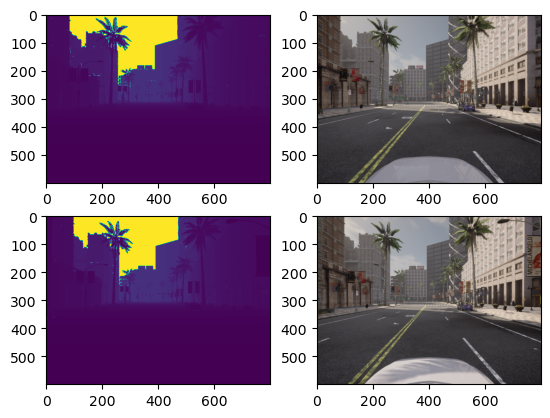

In [9]:
import matplotlib.pyplot as plt
# plt.imshow(depth_image1)
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(depth_image2)
ax[0,1].imshow(rgb_image2)
ax[1,0].imshow(depth_image1)
ax[1,1].imshow(rgb_image1)

In [35]:
image_0 = torch.from_numpy(rgb_image1).permute(2,0,1).unsqueeze(0).float()
image_1 = torch.from_numpy(rgb_image2).permute(2,0,1).unsqueeze(0).float()
depth_0 = torch.from_numpy(depth_image1).unsqueeze(0).unsqueeze(0).float()
depth_1 = torch.from_numpy(depth_image2).unsqueeze(0).unsqueeze(0).float()
image_q = torch.from_numpy(rgb_imageq).permute(2,0,1).unsqueeze(0).float()
depth_q = torch.from_numpy(depth_imageq).unsqueeze(0).unsqueeze(0).float()

In [36]:
  # image_0.min(), image_0.max()
depth_0.shape, depth_0.min(), depth_0.max()

(torch.Size([1, 1, 600, 800]), tensor(0.0013), tensor(1.))

In [37]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2], depth.shape[-1]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device)
    x = torch.linspace(0, 1, width,  device=depth.device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)


def project(points, K, height, width, invert=False):
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords


def perspective(points):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + 1e-7)


def transform(points, R,t, invert=False):
    """
    Project points to camera reference frame
    """
    # R, t = pose
    if invert:
        return R.mT @ (points - t)
    else:
        return R @ points + t


def disparity_to_depth(disparity, min_depth=0.1, max_depth=100.0):
    min_disparity = 1 / max_depth
    max_disparity = 1 / min_depth
    scaled = min_disparity + (max_disparity - min_disparity) * disparity
    depth = 1 / scaled
    return depth

In [39]:
import torchvision
import torch.nn.functional as F


# image_0 = torchvision.io.read_image("0000000000.png").unsqueeze(0) / 255.
# image_1 = torchvision.io.read_image("0000000001.png").unsqueeze(0) / 255.

device = 'cpu'

def pix_coords(height, width, device):
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    # print("torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)", torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1))
    # x,y,z=depth 
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)


def warp(homography, image, padding_mode="border"):
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=image.device)
    warped = project(homography @ coords, height, width)

    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    # print("gridsampled warped:", warped.shape)
    # backprojection 
    return warped


def reproject(depth, image, K, R, t):
    points_3d = backproject(depth, K)
    points_3d = transform(points_3d, R, t)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output


def residuals(params):
    """
    Return the loss of aligning image_1 to image_0 with homography (params).
    
    TODO: Replace the warp with backprojection (depth) and re-projection.
    """
    homography = params.view(3, 3)
    warped = warp(homography, image_1)
    output = ((image_0 - warped)**2).mean()
    # use unet on homography -test
    return output


def residuals_depth(params):
    transform = params.view(3, 4)
    sampled = reproject(depth_0*1000, image_0, K.to(device), transform[:, :3], transform[:, -1:])
    output = ((image_1 - sampled)**2).mean()
    return output


# homography = torch.eye(3).ravel()
#let image device = cpu
# homography = gauss_newton(homography, residuals, iterations=5, damping=1.0).view(3, 3)
transform_result = gauss_newton(torch.eye(3, 4).ravel(), residuals_depth, iterations=5, damping=0.27)

In [42]:
# transform_result.view(3, 4)
# R,t = transform_result.view(3, 4)[:, :3], transform_result.view(3, 4)[:, -1:]

In [ ]:
# temp=reproject(depth_0*1000, image_0, K, torch.eye(3),torch.zeros(3,1)+torch.tensor([0.000,0.000,-0.5]).view(3,1))
print(R, t)
temp = reproject(depth_0*1000, image_0, K, R, t)

tensor([[ 9.8767e-01, -3.0324e-03,  3.7140e-03],
        [ 2.3824e-03,  9.8750e-01, -7.3124e-04],
        [ 7.4214e-03, -7.9951e-03,  1.0246e+00]]) tensor([[-0.0001],
        [-0.0016],
        [ 0.0020]])


In [44]:
# # plt.imshow(temp[0].permute(1,2,0))
# fig,ax = plt.subplots(1,3,figsize=(15,10))
# ax[0].imshow(temp[0].permute(1,2,0)) # 
# ax[1].imshow(image_0[0].permute(1,2,0))
# ax[2].imshow(image_1[0].permute(1,2,0))

In [ ]:
depth_1.shape

torch.Size([1, 1, 600, 800])

# Back projects and other functions

In [26]:
# (F3_estimate,S3_estimate),(F2_estimate,S2_estimate),(F1_estimate,S1_estimate),(F0_estimate,S0_estimate) = net.forward(torch.Tensor(image_0))
import Unet as unet
net = unet.UNet(4,17)
# (F3_estimate,S3_estimate),(F2_estimate,S2_estimate),(F1_estimate,S1_estimate),(F0_estimate,S0_estimate) = net.forward(torch.Tensor(image_0))


In [27]:
import torchvision
import torch.nn.functional as F
device = 'cpu'

# image_0 = torchvision.io.read_image("0000000000.png").unsqueeze(0) / 255.
# image_1 = torchvision.io.read_image("0000000001.png").unsqueeze(0) / 255.

net = unet.UNet(4,17).to(device)
net.train()
def pix_coords(height, width, device):
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    # print("torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)", torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1))
    # x,y,z=depth 
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)


def warp(homography, image, padding_mode="border"):
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)

    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    # print("gridsampled warped:", warped.shape)
    # backprojection 
    return warped


def reproject(depth, image, K, R, t):
    points_3d = backproject(depth, K)
    points_3d = transform(points_3d, R, t)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output


def residuals(params):
    """
    Return the loss of aligning image_1 to image_0 with homography (params).
    
    TODO: Replace the warp with backprojection (depth) and re-projection.
    """
    homography = params.view(3, 3)
    warped = warp(homography, image_1)
    output = ((image_0 - warped)**2).mean()
    # use unet on homography -test
    return output

def huber_norm(x,gamma):
    
    # print("Fdiff", Fdiff)
    abs_x = torch.abs(x)
    mask1 = abs_x <= gamma
    mask2 = abs_x > gamma
    mask1 = mask1.float()*0.5*(x**2)
    mask2 = mask2.float()*gamma*(abs_x-gamma/2)
    result = torch.sum(mask1+mask2)
    return result 
def residuals_depth(params):
    index = pyramid_level 
    
    transform = params.view(3, 4)
    # sampled = reproject(depth_0*1000, image_0, K, transform[:, :3], transform[:, -1:]).to(device)
    sampled = reproject(depth_query_inResidual*1000, image_query_inResidual, K.to(device), transform[:, :3], transform[:, -1:]).to(device)
    # output = ((image_1 - sampled)**2).mean()
    # feature map of F(u'), the reprojected image
    (F3_estimate,S3_estimate),(F2_estimate,S2_estimate),(F1_estimate,S1_estimate),(F0_estimate,S0_estimate) = net.forward(sampled)
    # feature map of F(u)
    (F3,S3),(F2,S2),(F1,S1),(F0,S0) = net.forward(image_r.to(device))
    F_list = [F0,F1,F2,F3]
    S_list = [S0,S1,S2,S3]
    F_estimate_list = [F0_estimate,F1_estimate,F2_estimate,F3_estimate]
    S_estimate_list = [S0_estimate,S1_estimate,S2_estimate,S3_estimate]

    # huber norm
    Fdiff = F_list[index]-F_estimate_list[index]

    norm = huber_norm(Fdiff,gamma)


    # return torch.sum(S3*S3_estimate*(F3-F3_estimate)**2)
    return torch.sum(S_list[index]*S_estimate_list[index]*(norm))
pyramid_level = 3
gamma = 0.02
depth_query_inResidual = depth_q.to(device)
image_query_inResidual = image_q.to(device)
image_r = image_0.to(device)
test_result = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=5, damping=0.27)


In [28]:
def consistency_loss(Tr0r1,Tqr_list,Tqr_final):
    # return huber_norm(Tr0r1@torch.inverse(Tqr1_k)@Tqr0,1)
    loss = 0
    if Tr0r1.shape != (3,4):
        Tr0r1 = Tr0r1.view(3,4)
    # Turn transfomation to 4*4 matrix
    Tr0r1 = torch.cat((Tr0r1,torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
    Tqr_final = torch.cat((Tqr_final.view(3,4),torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
    # print("tr0r1",Tr0r1.shape,Tr0r1.type())
    # print("Tqr_final",Tqr_final.shape,Tqr_final.type())
    # print("tqrk shape",Tqr_list[0].shape,Tqr_list[0].type())
    for Tqr_k in Tqr_list:
        Tqr_k = torch.cat((Tqr_k.view(3,4),torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
        loss += huber_norm(Tr0r1@torch.inverse(Tqr_k)@Tqr_final,1)
        # loss += torch.sum(Tr0r1@torch.inverse(Tqr_k)@Tqr_final)

    return loss
    

In [29]:
R_r0r1 = torch.from_numpy(extrinsic2)[:3, :3] @ torch.inverse(torch.from_numpy(extrinsic1))[:3, :3]
t_r0r1 = torch.from_numpy(extrinsic2)[:3, -1] -  torch.from_numpy(extrinsic2)[:3, -1]
Tr0r1 = torch.cat((R_r0r1, t_r0r1.view(3, 1)), dim=1)

In [30]:
Tr0r1.ravel().view(3,4)

tensor([[ 1.0000e+00,  8.6943e-18,  0.0000e+00,  0.0000e+00],
        [ 4.1836e-16,  1.0000e+00,  2.5885e-18,  0.0000e+00],
        [-8.6736e-18, -1.1655e-18,  1.0000e+00,  0.0000e+00]],
       dtype=torch.float64)

In [33]:
# net = UNet(4,17)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = unet.UNet(4,17).to(device)
net.train()

from torch.optim import Adam
loss_history = []
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for i in range(10):
    # test_result = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    # loss = (residuals_depth(test_result) ** 2).mean()
    # loss_history.append(loss.item())
    # loss.backward()
    # optimizer.step()
    loss = 0
    # set query image and 2 reference image
    image_q = image_q.to(device)
    depth_q = depth_q.to(device)
    image_0 = image_0.to(device)
    depth_0 = depth_0.to(device)
    image_1 = image_1.to(device)
    depth_1 = depth_1.to(device)
    extrinsicq = extrinsicq
    extrinsic0 = extrinsic1
    extrinsic1 = extrinsic2
    # Find Tr0r1, Tr0r1 @ r0 = r1 
    R_r0r1 = torch.from_numpy(extrinsic1)[:3, :3] @ torch.inverse(torch.from_numpy(extrinsic0))[:3, :3]
    t_r0r1 = torch.from_numpy(extrinsic1)[:3, -1] -  torch.from_numpy(extrinsic0)[:3, -1]
    Tr0r1 = torch.cat((R_r0r1, t_r0r1.view(3, 1)), dim=1).to(device).float()
    Tr0r1.requires_grad = True
    # transofrmacy accuracy :

    K = K.to(device)
    # find Tq_r0, map image query to image r0 (now is image_0 to image 1)
    depth_query_inResidual = depth_q
    image_query_inResidual = image_q
    image_r = image_0
    # for each pyramid level 1-4
    # F0, S0 level
    pyramid_level = 0
    result_0_r0 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    # F1, S1 level
    pyramid_level = 1
    result_1_r0 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    # F2, S2 level
    pyramid_level = 2
    result_2_r0 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    # F3, S3 level
    pyramid_level = 3
    result_3_r0 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=5, damping=0.27)
    
    # find Tq_r1, map image query to image r1 (now is image_1 to image 1)
    image_r = image_1
    # for each pyramid level 1-4
    # F0, S0 level
    pyramid_level = 0
    result_0_r1 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    # F1, S1 level
    pyramid_level = 1
    result_1_r1 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    # F2, S2 level
    pyramid_level = 2
    result_2_r1 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    pyramid_level = 3
    result_3_r1 = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=5, damping=0.27)

    lc_r0r1_0 = consistency_loss(Tr0r1,result_0_r0,result_0_r1[-1])
    lc_r1r0_0 = consistency_loss(Tr0r1,result_0_r1,result_0_r0[-1])
    lc_r0r1_1 = consistency_loss(Tr0r1,result_1_r0,result_1_r1[-1])
    lc_r1r0_1 = consistency_loss(Tr0r1,result_1_r1,result_1_r0[-1])
    lc_r0r1_2 = consistency_loss(Tr0r1,result_2_r0,result_2_r1[-1])
    lc_r1r0_2 = consistency_loss(Tr0r1,result_2_r1,result_2_r0[-1])
    lc_r0r1_3 = consistency_loss(Tr0r1,result_3_r0,result_3_r1[-1])
    lc_r1r0_3 = consistency_loss(Tr0r1,result_3_r1,result_3_r0[-1])
    loss = lc_r0r1_3+lc_r1r0_3 + lc_r0r1_2+lc_r1r0_2 + lc_r0r1_1+lc_r1r0_1 + lc_r0r1_0+lc_r1r0_0 
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

  # train the UNet 

c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
loss_history

[1616.8282470703125,
 2013.765380859375,
 nan,
 18460.724609375,
 12033.138671875,
 nan,
 nan,
 7615.2490234375,
 nan,
 423.1225891113281]

In [154]:
result_3_r0

[tensor([ 0.9990, -0.0197, -0.0041,  0.0679, -0.0154,  0.9947, -0.0094,  0.0184,
          0.0117, -0.0014,  0.9992,  0.0150], device='cuda:0'),
 tensor([ 0.9096,  0.0610, -0.0468,  0.3529,  0.0263,  1.0150, -0.0563,  1.0567,
          0.0935,  0.1058,  0.9702,  2.2893], device='cuda:0'),
 tensor([  0.7581,  -2.2805,  -2.4527,   5.1731,   0.7630,   5.2837,   1.9574,
         -95.3931,   0.8713,   1.8111,   1.7488, -10.3396], device='cuda:0'),
 tensor([  0.1718,  -1.9892,   0.4022,  98.9440,   1.4108,   4.9169,   5.2078,
          61.1215,   1.2407,   2.2191,   1.7355, -29.0745], device='cuda:0'),
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        device='cuda:0')]

In [ ]:
T_ground_truth = torch.from_numpy(extrinsic2) @ torch.inverse(torch.from_numpy(extrinsic1))
R_gt, t_gt = T_ground_truth[:3, :3], T_ground_truth[:3, [-1]]
print("estimated transformation:", test_result.view(3,4))
print("ground truth:R_gt",R_gt,"\n  t_gt:",t_gt)

estimated transformation: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])
ground truth:R_gt tensor([[ 9.9996e-01,  3.1077e-03,  7.8854e-03],
        [-3.1083e-03,  1.0000e+00,  5.5392e-05],
        [-7.8852e-03, -7.9900e-05,  9.9997e-01]], dtype=torch.float64) 
  t_gt: tensor([[-1.4980e+00],
        [-1.3457e-03],
        [ 1.2945e-02]], dtype=torch.float64)


In [ ]:
net2 = UNet(4,17)

from torch.optim import Adam
loss_history2 = []
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.01)
net.train()
for i in range(8):
    test_result = gauss_newton(torch.eye(3, 4).ravel().to(device), residuals_depth, iterations=1, damping=0.27)
    loss = (residuals_depth(test_result) ** 2).mean()
    loss_history2.append(loss.item())
    loss.backward()
    optimizer2.step()
  # train the UNet 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 1.0214, -0.0151,  0.0463],
        [ 0.0073,  1.0280,  0.0578],
        [-0.0203,  0.0112,  0.9758]])


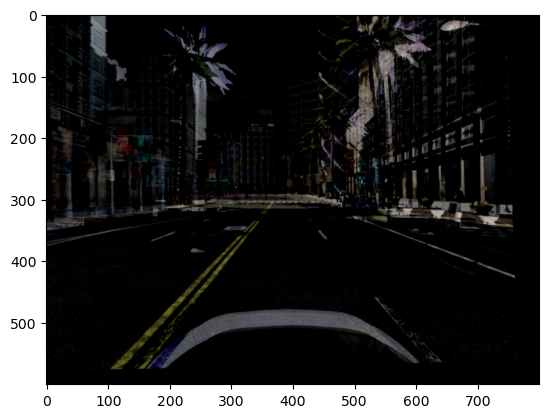

In [ ]:
warped = warp(homography, image_1, padding_mode='zeros')
print(homography)

plt.imshow((warped - image_0)[0].permute(1,2,0))
plt.show()

We can now go a step further and try to optimize the `damping` parameter, because we added some tricks to make the optimization itself end-to-end differentiable. A step size of `1` may not always be a good choice, and in the case of direct image registration, it probably isn't.

We will do this by running our differentiable optimizer with the same initial guess, and minimizing the residuals after 5 iterations.

In [ ]:
from torch.optim import Adam

damping = torch.tensor(1.0, requires_grad=True)

optimizer = Adam([damping], lr=0.1)

loss_history = []
for i in range(0, 10):
    optimizer.zero_grad()
    guess = torch.eye(3).ravel()
    homography = gauss_newton(guess, residuals, damping=damping, iterations=5)
    loss = (residuals(homography) ** 2).mean()
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

In [ ]:
print(f"A better step size for this problem is {damping}")

A better step size for this problem is 0.2781076729297638


Does an optimized damping parameter improve on the results of our residuals?

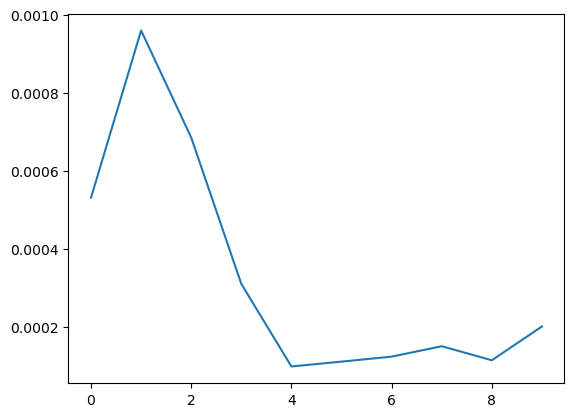

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 1.0067e+00,  6.6919e-03, -1.3772e-02],
        [-8.7410e-04,  1.0132e+00,  1.3469e-02],
        [-5.0743e-03,  1.3053e-02,  9.7994e-01]], requires_grad=True)


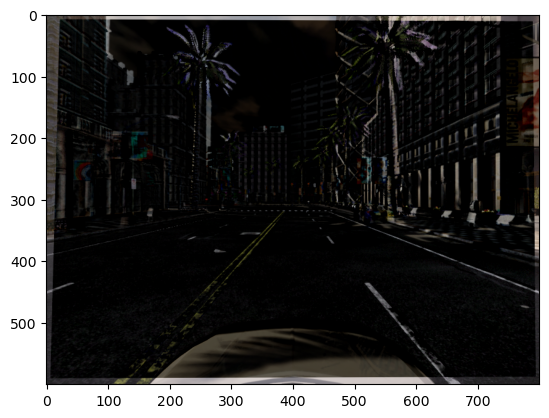

In [ ]:
with torch.no_grad():
    warped = warp(homography.view(3, 3), image_1, padding_mode='zeros')
    print(homography.view(3, 3))

    plt.imshow((image_0 - warped)[0].permute(1,2,0))
    plt.show()